In [11]:
import torch
from PIL import Image
from diffusers import ControlNetModel, DiffusionPipeline, DDIMScheduler
from diffusers.utils import load_image
from torchvision import transforms as tfms

In [2]:
import torch
from PIL import Image
from diffusers import ControlNetModel, DiffusionPipeline, DDIMScheduler
from diffusers.utils import load_image

def resize_for_condition_image(input_image: Image, resolution: int):
    input_image = input_image.convert("RGB")
    W, H = input_image.size
    k = float(resolution) / min(H, W)
    H *= k
    W *= k
    H = int(round(H / 64.0)) * 64
    W = int(round(W / 64.0)) * 64
    img = input_image.resize((W, H), resample=Image.LANCZOS)
    return img

source_image = load_image('https://github.com/lllyasviel/ControlNet-v1-1-nightly/raw/main/test_imgs/dog64.png')
condition_image = resize_for_condition_image(source_image, 512)

/tmp/ipykernel_3664/884104601.py:14: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = input_image.resize((W, H), resample=Image.LANCZOS)


In [3]:
controlnet = ControlNetModel.from_pretrained('takuma104/control_v11', 
                                             subfolder='control_v11f1e_sd15_tile',
                                             torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    custom_pipeline="invertible_controlnet_img2img",
    controlnet=controlnet,
    torch_dtype=torch.float16).to('cuda')
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.safety_checker = None

/mnt/disks/main/.cache/huggingface/modules/diffusers_modules/local/pipeline.py:26: FutureWarning: Importing `StableDiffusionControlNetPipeline` or `MultiControlNetModel` from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_controlnet is deprecated. Please import `from diffusers import StableDiffusionControlNetPipeline` instead.
  from diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_controlnet import (
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [7]:
# Decode the final inverted latents:
def visualize_latents(l):
    with torch.no_grad():
        im = pipe.decode_latents(l.unsqueeze(0))
    return pipe.numpy_to_pil(im)[0]

In [203]:
# source_image = load_image('https://github.com/lllyasviel/ControlNet-v1-1-nightly/raw/main/test_imgs/dog64.png')
# condition_image = resize_for_condition_image(source_image, 512)
source_image = load_image('./data/woman_dance_in_street/040.png')
# source_image = my_load_image('https://images.pexels.com/photos/8306128/pexels-photo-8306128.jpeg', size=(512, 512))
# source_image = resize_for_condition_image(source_image, 512)
condition_image = load_image('./data/woman_dance_in_street/050.png')
condition_image = resize_for_condition_image(condition_image, 512)

/tmp/ipykernel_3664/884104601.py:14: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = input_image.resize((W, H), resample=Image.LANCZOS)


In [226]:
def invert(
        image, 
        prompt, 
        negative_prompt,
        guidance_scale, 
        num_inference_steps
    ):
    with torch.no_grad(): latent = pipe.vae.encode((tfms.functional.to_tensor(image).unsqueeze(0).to('cuda')*2-1).half())
    l = 0.18215 * latent.latent_dist.sample()
    print(guidance_scale)
    inverted_latents = pipe.invert(
        l, 
        prompt=prompt, 
        negative_prompt=negative_prompt,
        guidance_scale=guidance_scale, 
        num_inference_steps=num_inference_steps
    )
    return inverted_latents

pipe.safety_checker = None
start_step = 10
num_inference_steps = 250
guidance_scale = 3.5
# prompt = "a photo of woman dancing, best quality"
prompt = ""
# negative_prompt = "bad anatomy, low quality"
negative_prompt = ""

In [227]:
inverted_latents = invert(
    image=source_image, 
    prompt=prompt,
    negative_prompt=negative_prompt,
    guidance_scale=guidance_scale, 
    num_inference_steps=num_inference_steps
)
inverted_latents.shape

1


100%|█████████▉| 248/249 [00:39<00:00,  6.22it/s]


torch.Size([248, 4, 64, 64])

  0%|          | 0/240 [00:00<?, ?it/s]

100%|██████████| 240/240 [00:32<00:00,  7.40it/s]


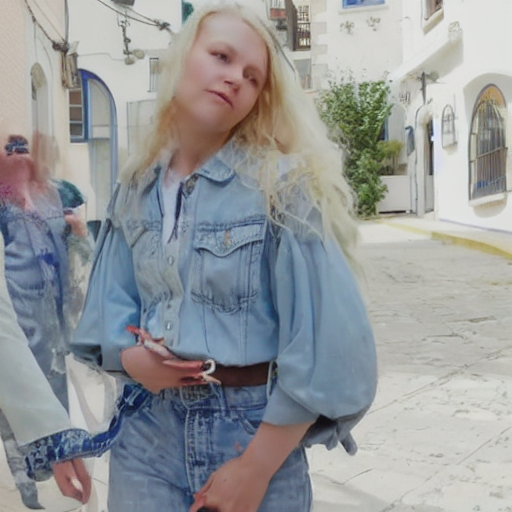

In [235]:
do_cn = True
do_inv = True
cn_end = 1.0
cn_scale = 0.02

if do_inv:
    latents = inverted_latents[-(start_step + 1)][None]
    start_step_gen = start_step
else:
    latents = None
    start_step_gen = 0

pipe(
    prompt=prompt, 
    negative_prompt=negative_prompt,
    image=condition_image, 
    controlnet_conditioning_image=condition_image, 
    width=condition_image.size[0],
    height=condition_image.size[1],
    strength=1, 
    generator=torch.manual_seed(0),
    num_inference_steps=num_inference_steps, 
    guidance_scale=guidance_scale, 
    controlnet_guidance_end=cn_end,
    controlnet_conditioning_scale=cn_scale,
    latents=latents, 
    start_step=start_step_gen,
).images[0]

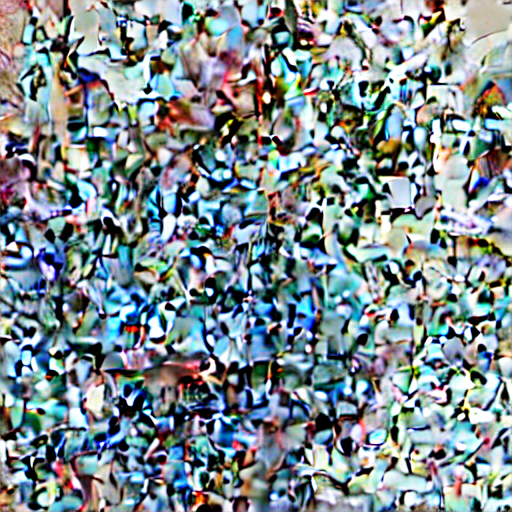

In [208]:
visualize_latents(latents[0])

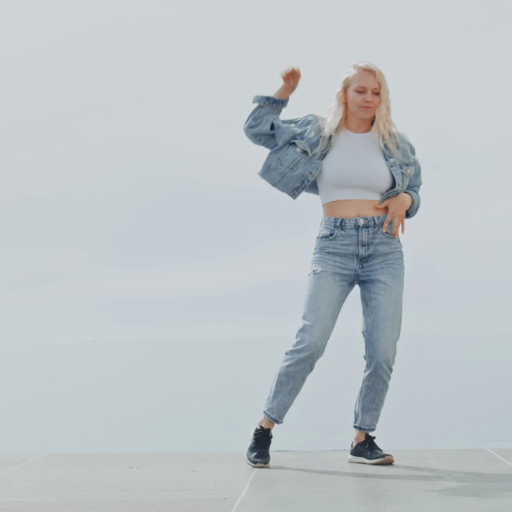

In [69]:
condition_image